In [15]:
# Importar librerías para análisis y manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Preparación de datos y partición
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Modelo Random Forest
from sklearn.ensemble import GradientBoostingRegressor

# Evaluación del modelo
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, make_scorer, r2_score

In [16]:
df = pd.read_csv('/kaggle/input/viviendas-modelos/viviendas_model.csv')

In [17]:
# Activamos o desactivamos en caso de que queramos tener en cuenta o no las variables economicas
df = df.drop([
    'Paro hombre edad < 25',
    'Paro hombre edad >=45',
    'Paro mujer edad < 25',
    'Paro mujer edad 25 -45 ',
    'Paro Agricultura',
    'Paro Industria',
    'Paro construccion',
    'Paro Servicios',
    'Paro Sin empleo Anterior',
    'Mediana de la renta por unidad de consumo',
    'Renta bruta media por persona',
    'Renta neta media por persona ',
    'Renta bruta media por hogar',
    'total Paro Registrado']
        ,axis=1)

In [18]:
# Verificar si hay datos faltantes
def check_missing_data(df):
    hay_nan = df.isnull().values.any()
    print(f"¿Hay algún NaN en el DataFrame? {hay_nan}")

    nan_por_columna = df.isnull().sum()
    print("Cantidad de NaN por columna:\n", nan_por_columna)

    filas_con_nan = df[df.isnull().any(axis=1)]
    print("Filas que contienen NaN:\n", filas_con_nan)

    return hay_nan, nan_por_columna, filas_con_nan

In [19]:
hay_nan, nan_por_columna, filas_con_nan = check_missing_data(df)
if hay_nan:
    df = df.dropna()
hay_nan, nan_por_columna, filas_con_nan = check_missing_data(df)

¿Hay algún NaN en el DataFrame? True
Cantidad de NaN por columna:
 Caracteristicas     0
Habitaciones        0
Aseos               0
Terraza             0
Piscina             0
Garaje              0
Precio              0
Metros              0
CodigoPostal        1
Latitud             0
Longitud            0
precio_por_metro    0
precio_medio_m2     0
dtype: int64
Filas que contienen NaN:
        Caracteristicas  Habitaciones  Aseos  Terraza  Piscina  Garaje  \
48472                5           2.0    2.0        1        0       0   

         Precio  Metros  CodigoPostal  Latitud  Longitud  precio_por_metro  \
48472  219000.0    86.0           NaN    15893     19547       2546.511628   

       precio_medio_m2  
48472      3775.926841  
¿Hay algún NaN en el DataFrame? False
Cantidad de NaN por columna:
 Caracteristicas     0
Habitaciones        0
Aseos               0
Terraza             0
Piscina             0
Garaje              0
Precio              0
Metros              0
CodigoPost

In [20]:
# Características y etiqueta
X = df.drop('Precio', axis=1)
y = df['Precio']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=101)

# Guardar los índices originales de X_test antes de escalar
X_test_indices = X_test.index

# Escalado de características
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test_indices, columns=X_test.columns)

In [22]:
# Crear el modelo Random Forest
gbr_model = GradientBoostingRegressor(random_state=42)

In [23]:
# Crear un KFold para la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar el modelo utilizando la validación cruzada
cv_results = cross_val_score(gbr_model, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error')

# Calcular la media y la desviación estándar del MSE
mean_mse = np.mean(np.abs(cv_results))
std_mse = np.std(cv_results)

print(f'Mean MSE: {mean_mse}')
print(f'Standard Deviation of MSE: {std_mse}')

Mean MSE: 191467125.86213487
Standard Deviation of MSE: 7707156.94010815


In [24]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10]
}

# Crear el GridSearchCV
grid_search = GridSearchCV(estimator=gbr_model, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Ajustar el GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Mejor combinación de hiperparámetros
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}


In [25]:
# Evaluar el mejor modelo
best_gbr_model = grid_search.best_estimator_

# Evaluar en el conjunto de prueba
best_test_predictions = best_gbr_model.predict(X_test_scaled)
best_test_mse = mean_squared_error(y_test, best_test_predictions)
best_test_rmse = np.sqrt(best_test_mse)

print(f'Best Test MSE: {best_test_mse}')
print(f'Best Test RMSE: {best_test_rmse}')

Best Test MSE: 76252418.8723354
Best Test RMSE: 8732.263101415085


In [26]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    
    print(f'R2: {r2}')
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    
    # Grafica de la dispersión y la línea de regresión
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions, color='blue', alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
    plt.xlabel('Valores Reales')
    plt.ylabel('Valores Predichos')
    plt.title('Valores Reales vs. Valores Predichos')
    plt.grid(True)
    plt.savefig('/kaggle/working/regression_plot.png')
    plt.show()

R2: 0.9983450958077513
MAE: 1440.5681362000296
MSE: 76252418.8723354


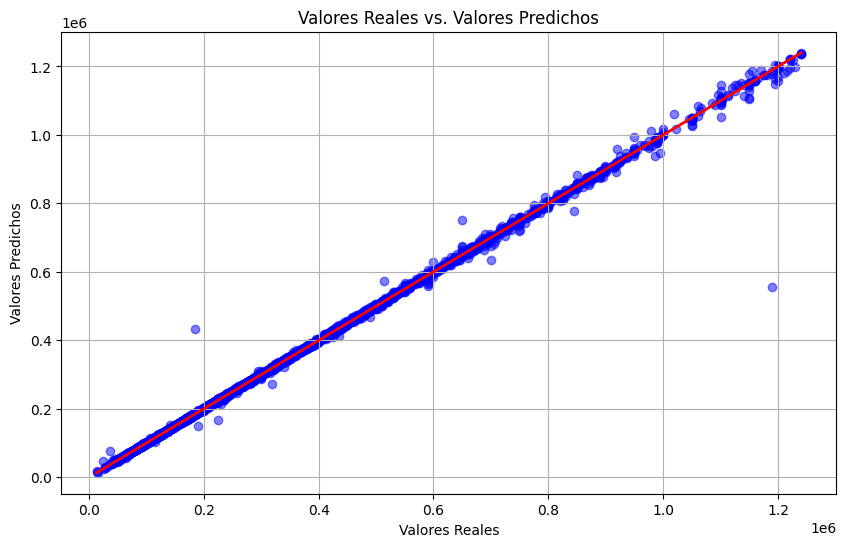

In [27]:
evaluate(best_gbr_model, X_test_scaled, y_test)

In [28]:
# Seleccionar aleatoriamente un inmueble del conjunto de prueba
random_inmueble_index = np.random.choice(X_test_indices)
random_inmueble = X_test_scaled_df.loc[random_inmueble_index].values.reshape(1, -1)
precio_predicho = best_gbr_model.predict(random_inmueble)

precio_real = y_test.loc[random_inmueble_index]

# Imprimir el precio real y el precio predicho
print(f'El precio real del inmueble seleccionado aleatoriamente es: {precio_real}')
print(f'El precio predicho del inmueble seleccionado aleatoriamente es: {precio_predicho[0]}')


El precio real del inmueble seleccionado aleatoriamente es: 100000.0
El precio predicho del inmueble seleccionado aleatoriamente es: 99722.87629388402
